In [11]:
'''
Reference paper: "A ZTF Search for Circumstellar Debris Transits in White Dwarfs: 
Six New Candidates, one with Gas Disk Emission, identified in a Novel Metric Space"

Gas Disk model developed in Section 5.2 in the paper

Author: Soumyadeep Bhattacharjee

Contact: sbhatta2@caltech.edu
'''


import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import emcee
from scipy.optimize import curve_fit
import matplotlib as mpl
import scipy
from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel

msun = 1.989e33
mwd = 0.64*msun
rsun = 6.9634e10
rwd = 0.01*rsun
g = 6.6743e-8
twd = 21900
kb = 1.3806e-16
mH = 1.67356e-24
h = 6.62618e-27
c = 2.998e10

CB = ['#377eb8','#ff7f00','#228B22','#f781bf', 
      '#a65628','#984ea3','#999999','#c43a1c', 
      '#dede00','#222222','#DD8F07']

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    rgb = colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    hexcol = mc.to_hex(rgb)
    return hexcol

lcolors = []
for e in CB:
    el = lighten_color(e,amount=0.5)
    lcolors.append(el)
    
dcolors = []
for e in CB:
    ed = lighten_color(e,amount=1.0)
    dcolors.append(ed)
    
mpl.rcParams.update(
     {# Use mathtext, not LaTeX
     'text.usetex': False,
     'axes.formatter.use_mathtext': True,
     # Set the fonts
     'font.family': 'STIXGeneral',
     'mathtext.fontset': 'cm',
     # Use ASCII minus
     'axes.unicode_minus': False,
    'axes.linewidth':1.5
})

data = pd.read_csv('ca_data_new.csv')
xd = data.vel.values
yd = data.flux.values
yderr = data.fluxerr.values

In [12]:
def melis_pol_par(Ts, nuL = 3.46e14, hnuI = 1.2817e-11):
    mca = 40*mH
    
    ## Grid of distances (in units of stellar radius)
    r_grid = np.arange(20,300,1)
    
    ## Equation 3
    xI = hnuI/(kb*Ts)
    
    ## Solve integral in Eq. 2
    def func(x):
        return ((x**3)-(xI*(x**2)))*np.exp(-x)
    
    integral,_ = scipy.integrate.quad(func, xI, np.inf)
    
    ## LHS factor without Tg and exponent
    fact_lhs = 12*np.sqrt(2*kb/mca)*2*np.pi*h*(nuL**4)/(c**3)
    
    ## RHS factor without Tg and r
    fact_rhs = (2/3)*(2*h/(c**2))*((kb*Ts/h)**4)*integral
    
    ## Taking LHS factor to the right and devding by (r/R_star)**3
    fact = fact_rhs/fact_lhs
    rhss = fact/(r_grid**3)
    
    ## Tg grid to find the solution from minimum distance
    tg_grid = np.arange(100, 21000, 1)
    
    ## The exponent in LHS
    exp = np.exp(-h*nuL/(kb*tg_grid))
    lhss = np.sqrt(tg_grid)*exp
    
    ## Solve for the gas temperature using grids
    temps = []
    for rhs in rhss:
        diff = abs(lhss - rhs)
        min_index = np.where(diff==min(diff))[0][0]
        temps.append(tg_grid[min_index])
        
    ## Fit with a polynomial for future use
    melis_par = np.polyfit(r_grid, temps, deg = 10)
    
    return melis_par

In [15]:
#### Defining the optical thick gas disk model ########

melis_par = melis_pol_par(21900)

def disc_model_othick(vels, e, ain, aout, losphi, logconst, alpha, inc, logtau0, cen_vel, resolution = 40):
    
    ##### Resampling velocity to downresolved later #####
    resample_vels = np.linspace(-2000.0, 2000.0, 2000)
    
    ##### Shifting the velocity to central velocity ######
    vels = vels - cen_vel
    
    ##### Defining the integral sections and LOS #########
    nsteps = int(aout-ain)
    asteps = np.linspace(ain,aout,nsteps)
    los_cos = [np.cos(losphi),np.sin(losphi)]
    res = len(vels)
    nlsteps = (1*(10**3))
    qsteps = np.linspace(0,2*np.pi,nlsteps)

    ##### Initializing the spectrum #########
    spectrum_total = np.zeros(res)
    
    
    tau0 = 10**(logtau0)
    const = 10**(logconst)
    
    ###### Function defining the thermal width of emission #########
    ###### When the Melis temperature > 21 kK, we have limited it to this value ########
    def sigma(r, twd=twd, rwd=rwd):
        temp = np.polyval(melis_par, r)
        hightemp = temp>21000
        temp[hightemp] = 21000
        sigma = np.sqrt(temp/(40*121))
        return sigma

    ##### Some appropriately normalized photon flux as a function of distance #######
    ##### The normalization is ingested into the arbitraty normalization constant #######
    def phot_flux(r, alpha=alpha):
        return (r/50)**(-alpha)

    ###### Defining Keplerian orbital velocity #############
    def vel(r, a, mwd=mwd, rwd=rwd, g=g):
        velcm = np.sqrt(g*mwd/rwd)*np.sqrt(((2/r)-(1/a)))
        velkm = velcm/1e5
        return velkm

    ######## distance (r) from the WD as a function of the focal angle #######
    def rq(q, e, a):
        fact1 = a*(1-(e**2))
        fact2 = 1+(e*np.cos(q))
        return fact1/fact2

    ######### Computing the velocity unit vector #######
    def veldir(q, e):
        facty = e+np.cos(q)
        fact2 = np.sqrt(1+(e**2)+(2*e*np.cos(q)))
        factx = -np.sin(q)
        cosx = factx/fact2
        cosy = facty/fact2
        return cosx, cosy

    ###### Defining the Gaussian width ############
    def gaussian(v, vc, intens, sig=3):
        return (
            intens / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((v - vc) / sig, 2.0) / 2)
        )
    

    for ai in range(len(asteps)):
        ##### Calculating spectra for each right then adding up #######
        ##### Done in a matrix format, where axis=0 are the aximuthal elements and axis=1 is the wavelength ####
        
        a = asteps[ai]
        spectrum = np.zeros(res)
        delq = np.diff(qsteps)[0]
        
        #### dens=1, thus constant. Can be changed by adding appropriate distance profiles ####
        dens = 1.0
        
        r = rq(qsteps, e, a)
        sig = sigma(r)
        v = vel(r,a)
        
        #### Calculating the velocity unit vectors #####
        vx, vy = veldir(qsteps, e)
        
        #### This is the angle between the tangent and the normal to the position vector ######
        pos_proj = abs((vx*np.sin(qsteps))-(vy*np.cos(qsteps)))
        
        #### This is the length element along the ellipse for a delta(q) and position ###### 
        dell = delq*r/pos_proj
        
        #### Implementing Equation 16 in the paper in the exponent ######
        vnorm = sum(dell/v)
        tau = tau0*sum(dell)*dens/v/vnorm/np.cos(inc)
        
        ###### los_proj = cos(LOS projection angle) ######
        los_proj = (vx*los_cos[0])+(vy*los_cos[1])
        
        ###### Calculating the shear and total velocity width (Equation 20 in paper) ######
        los_proj_theta = np.arccos(los_proj)
        Q = np.sin(inc)*np.tan(inc)
        sig_shear = sig*np.sqrt(1+((Q*np.sin(2*los_proj_theta))**2))
        
        #### Defining the projected central velocity #####
        vproj = v*los_proj*np.sin(inc)
        
        #### Storing the quantities in a matrix ########
        vproj_matrix = np.tile(np.array([vproj]).transpose(), (1, res))
        vels_matrix = np.tile(np.array([vels]), (nlsteps, 1))
        tau_matrix = np.tile(np.array([tau]).transpose(), (1, res))
        sig_shear_matrix = np.tile(np.array([sig_shear]).transpose(), (1, res))
        phot_flux_matrix = np.tile(np.array([phot_flux(r)]*dell).transpose(), (1, res))
        
        ##### Calculating luminosities for Keplerian rings and adding (Equation 17 in paper) #######
        taus = gaussian(vels_matrix, vproj_matrix, tau_matrix, sig=sig_shear_matrix)
        spectra = phot_flux_matrix*(1-np.exp(-taus))
        spectrum = np.sum(spectra, axis=0)
        
        ###### Downresolving the spectrum to desired resolution ############
        resampled_spectrum = np.interp(resample_vels, vels, spectrum)
        
        gauss_kernel = Gaussian1DKernel(resolution)
        spectrum_conv = convolve(resampled_spectrum, gauss_kernel)
        
        spectrum = np.interp(vels, resample_vels, spectrum_conv)
        
        
        spectrum_total = spectrum_total + spectrum
    
    return const*spectrum_total

Text(0.5, 0, 'Velocity $({\\rm km~s^{-1}})$')

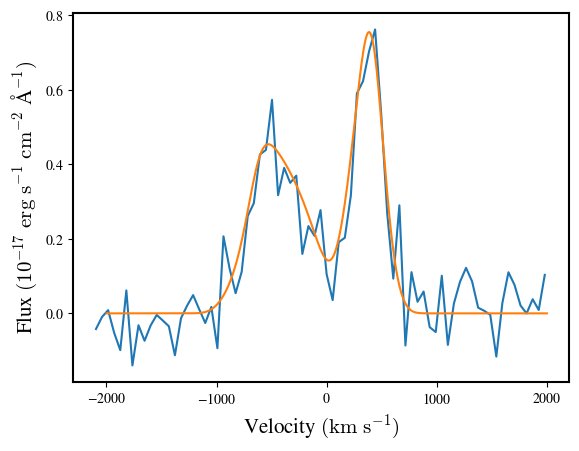

In [31]:
#### Plotting a representative fit using the optimum values in the paper ######

vels = np.linspace(-2000, 2000, 500)
model = disc_model_othick(vels, 0.27, 18.21, 47.91, 4.69, -2.78, -0.4, 1.41, 8.06, 43.01)

plt.plot(xd, yd, label = 'Data')
plt.plot(vels, model, label = 'Model')

plt.ylabel(r'Flux $(10^{-17}~{\rm erg~s^{-1}~cm^{-2}~\AA^{-1}})$', fontsize=15)
plt.xlabel(r'Velocity $({\rm km~s^{-1}})$', fontsize=15)

## Below is the MCMC implementation

In [3]:
#### Defining the log likelihood function (Equation 22 in paper) ######
def log_likelihood(theta, x, y, yerr):
    e, ain, aout, losphi, logconst, alpha, inc, logtau0, cen_vel = theta
    model = disc_model_othick(x, e, ain, aout, losphi, logconst, alpha, inc, logtau0, cen_vel)
    sigma2 = (yerr**2)
    loglike = -0.5 * np.nansum((y -model) ** 2 / sigma2)
    return loglike

In [4]:
###### Defining the Priors ########

def uniform_prior(x, a, b):
    if a<=x<=b:
        return -np.log(b-a)
    else:
        return -np.inf
    
def log_prior(theta):
    lp = 0
    e, ain, aout, losphi, logconst, alpha, inc, logtau0, cen_vel = theta
    lp+=uniform_prior(e, 0, 1)
    lp+=uniform_prior(ain, 1, 150)
    lp+=uniform_prior(aout, ain, 300)
    lp+=uniform_prior(losphi, 0, 2*np.pi)
    lp+=uniform_prior(alpha, -3, 3)
    lp+=uniform_prior(logconst, -5, -1)
    lp+=uniform_prior(inc, 0, np.pi/2)
    lp+=uniform_prior(logtau0, 0, 15)
    lp+=uniform_prior(cen_vel, 0, 100)
    return lp

###### Generate the log probability #######
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [ ]:
##### Defining initial guesses and randomizing it #######

etrue = 0.2
aintrue = 15
aouttrue = 60
losphitrue = 4.5
alphatrue = 0.05
logconsttrue = -3.0
Qtrue = 1.0
logtau0true = 8
cen_veltrue = 40
true_param = np.array([etrue, aintrue, aouttrue, losphitrue, logconsttrue, alphatrue, Qtrue, logtau0true, cen_veltrue])

pos = []
for i in range(30):
    rand_num = np.random.uniform(-0.3,0.31,9)
    pos_temp = true_param+(rand_num*true_param)
    pos = pos+[pos_temp.tolist()]
pos = np.array(pos)

In [ ]:
###### Run the MCMC #######

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(xd, yd, yderr)
)
sampler.run_mcmc(pos, 8000, progress=True)

In [25]:
##### Loading a saved MCMC run ######

flat_samples = np.load('samples_thinned_data_lris_model_with_projection.npy')
flat_samples_prob = np.load('sampler_thinned_flatprobability_data_lris_model_with_projection.npy')

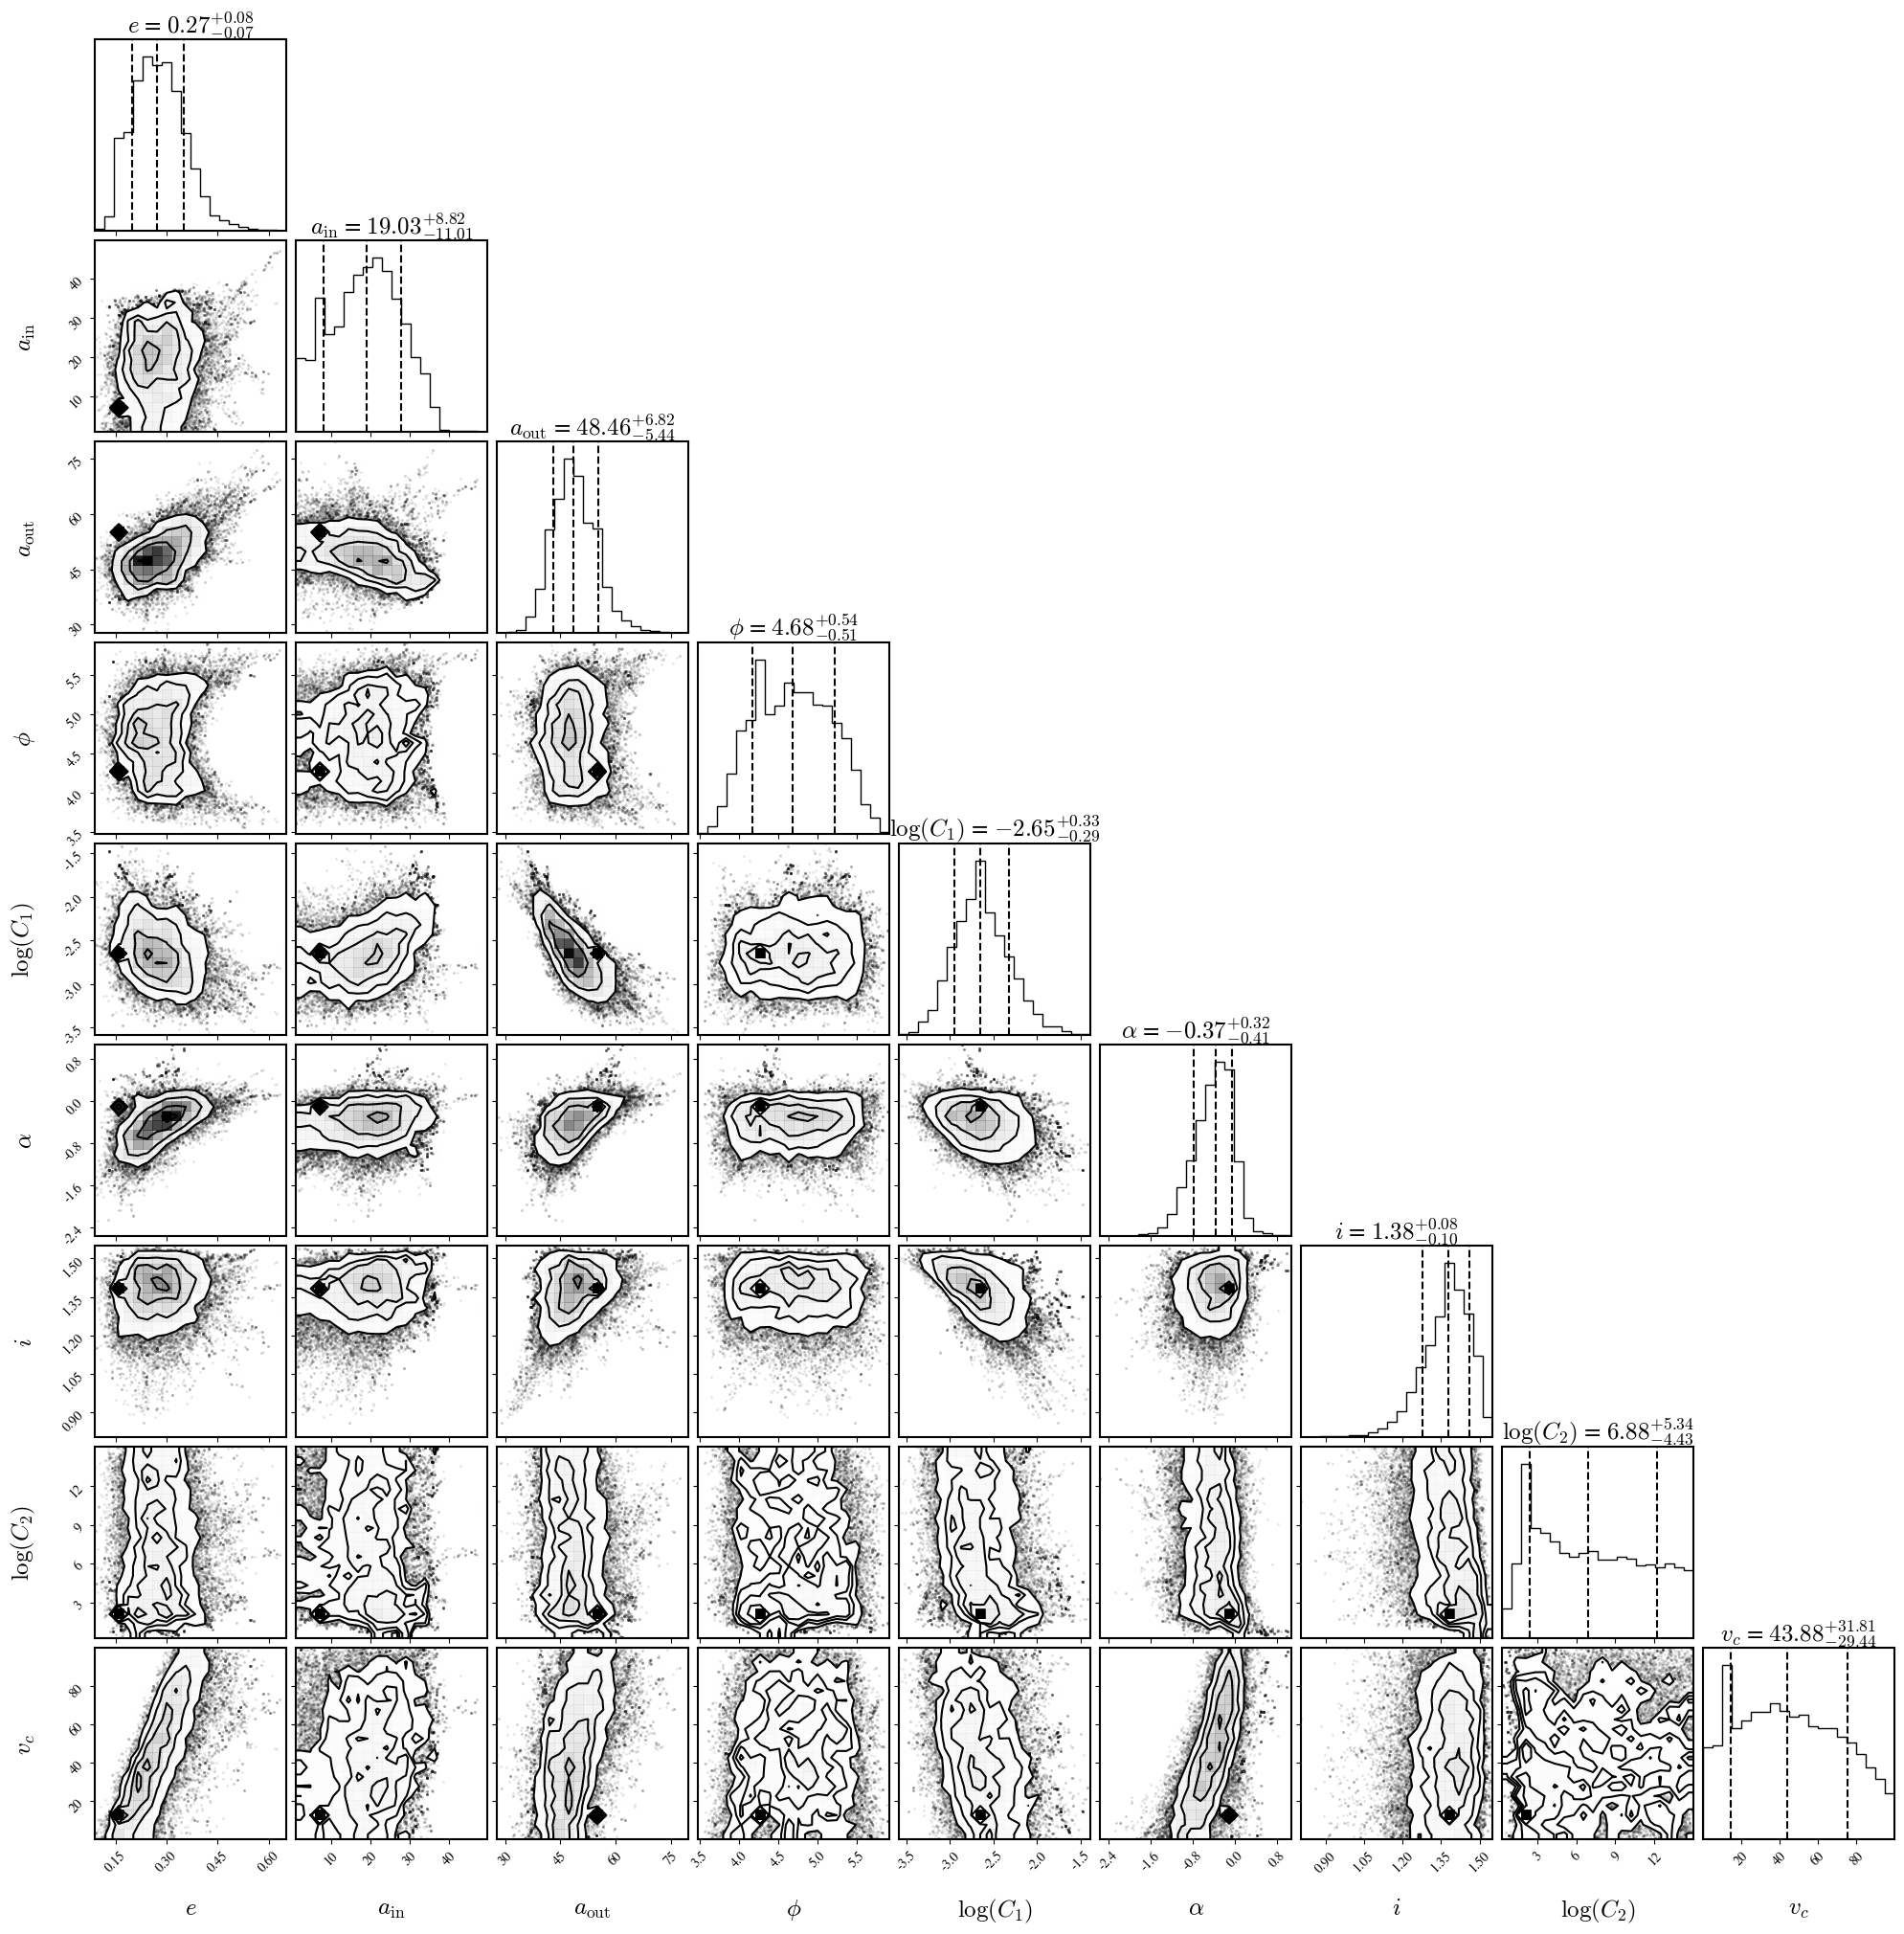

In [26]:
###### Plotting the corner plot (Figure 14) ########

import corner

labels = [r"$e$", r"$a_{\rm in}$", r"$a_{\rm out}$", r"$\phi$", r"$\log(C_1)$", r"$\alpha$", r'$i$', r'$\log(C_2)$', r'$v_c$']

#flat_samples = sampler.get_chain(discard=2000, thin=5, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, show_titles=True, plot_datapoints=True,quantiles=[0.16, 0.5, 0.84],
    label_kwargs=dict(fontsize=18),
    title_kwargs=dict(fontsize=18),
);

#flat_samples_prob = sampler.get_log_prob(discard=2000, thin=5, flat=True)

#plt.savefig('./dust_disc_model_corner_plot_data.png',dpi=100,bbox_inches='tight')

/var/folders/b8/9fnjjk5s3v59b43phd2k162m0000gn/T/ipykernel_1309/3061028724.py:102: RuntimeWarning: invalid value encountered in arccos
  los_proj_theta = np.arccos(los_proj)


(-2000.0, 2000.0)

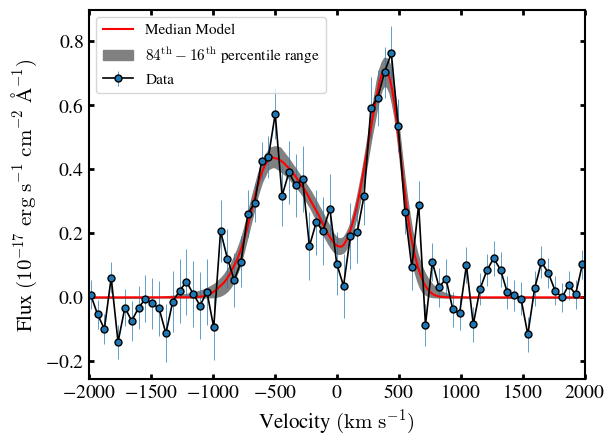

In [29]:
###### Generating the model fit (Figure 13) ########
x0 = np.linspace(min(xd), max(xd), 200)

def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for theta in thetas:
        mod = disc_model_othick(x0, *theta)
        models.append(mod)
    med_model = np.nanmedian(models,axis=0)
    spread_up = abs(np.nanquantile(models,0.84, axis = 0)-med_model)
    spread_down = abs(np.nanquantile(models,0.16, axis = 0)-med_model)
    return med_model, spread_up, spread_down
med_model, spread_up, spread_down = sample_walkers(200,flat_samples)

####### Plotting it #########

plt.errorbar(xd, yd, yderr, c='k', label='Data', linewidth = 1.2,
            ls='-',marker='o',mfc='C0',mec='k',ms=5,zorder=2,
                        ecolor='C0',elinewidth=0.5)

plt.plot(x0,med_model,label='Median Model', c='red')
plt.fill_between(x0,med_model-spread_down,med_model+spread_up,color='grey',alpha=1.0,label=r'${\rm 84^{th}-16^{th}}$ percentile range')
plt.legend(loc = 'upper left')

plt.tick_params(which='both',direction='in',top=True,right=True,labelsize=14,labelbottom = True, width=2)
plt.legend(loc = 'upper left', fontsize = 11)
plt.ylabel(r'Flux $(10^{-17}~{\rm erg~s^{-1}~cm^{-2}~\AA^{-1}})$', fontsize=15)
plt.xlabel(r'Velocity $({\rm km~s^{-1}})$', fontsize=15)

plt.xlim(-2000, 2000)

#plt.savefig('../Paper_Plot/dust_disc_model_fit_data.png',dpi=300,bbox_inches='tight')